In [1]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## Загрузите эмбеддинги слов

In [2]:
from tqdm import tqdm_notebook as tqdm #не принтует у меня каждый новый процент

In [3]:
def load_embeddings(path, num_tokens=100_000):
    
    token2index: Dict[str, int] = dict()
    embeddings = list()
            
    with open(path, "r", encoding="utf-8") as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()
        vocab_size, embedding_dim = int(vocab_size), int(embedding_dim)
                
        num_tokens = vocab_size if num_tokens <= 0 else num_tokens
        
        token2index["<PAD>"] = 0
        embeddings.append(np.zeros(embedding_dim))

        token2index["<UNK>"] = 1
        embeddings.append(np.ones(embedding_dim))
        
        progress_bar = tqdm(total=num_tokens, disable=False, desc='Reading embeddings file')
        
        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in token2index:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            token2index[token] = len(token2index)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(token2index) == num_tokens:
                break

        progress_bar.close()
        
    embeddings_matrix: np.array = np.stack(embeddings)
    
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

In [4]:
## Раскомментируйте и скачайте эмбеддинги
#!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
#!gzip -d cc.ru.300.vec.gz

In [5]:
token2index, embeddings_matrix = load_embeddings('cc.ru.300.vec')
embeddings_matrix.shape

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Reading embeddings file:   0%|          | 0/100000 [00:00<?, ?it/s]

(100000, 300)

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [6]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/home/yudina/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/yudina/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/yudina/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


In [15]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        return [self.token2index.get(token, self.unk_index) for token in tokenized_text]
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        new_tokens_indices = []
        flag = False
        for i in tokens_indices:
            if i == self.unk_index:
                if flag is False:
                    flag = True
                    new_tokens_indices.append(i)
            else:
                flag = False
                new_tokens_indices.append(i)
        if len(new_tokens_indices) > self.max_length:
            return new_tokens_indices[:self.max_length]
        pad_indices = [self.pad_index] * max(self.max_length - len(new_tokens_indices), 0)
        return new_tokens_indices[:self.max_length] + pad_indices
                
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        return self.padding(self.indexing(self.tokenize(text)))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self(sample["text"]))
            labels.append(sample["label"])
            
        tokenized_texts = torch.tensor(tokenized_texts) # перевод в torch.Tensor
        labels = torch.tensor(labels) # перевод в torch.Tensor
        
        return tokenized_texts, labels

In [16]:
tokenizer = Tokenizer(
    base_tokenizer=ToktokTokenizer(),
    token2index=token2index,
    pad_token="<PAD>",
    unk_token="<UNK>",
    max_length=100
)

## <Место для реализации>

In [17]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)

In [18]:
for x, y in train_loader:
    break

In [19]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрала метрику f1_score (average='weighted')
Почему я выбрала эту метрику:  

1) Я быстро посмотрела на данные с помощью гистограмм и увидела, что 3 класса (0, 1, 2) очень несбалансированы (меньше всего класса 0, больше - 1)

2) Значит, нужно выбирать метрику с учетом задачи многоклассовой классификации при несбалансированных классах

Самый очевидный вариант - метрика f1_score c параметром average='weighted'. Она вычисляет f1-метрику для каждого класса, а затем возвращает усредненную метрику с учетом соотношения классов. Именно это позволяет учесть дибаланс классов. 

In [20]:
train_data = [x["label"] for x in train_dataset]
valid_data = [x["label"] for x in valid_dataset]
test_data = [x["label"] for x in test_dataset]

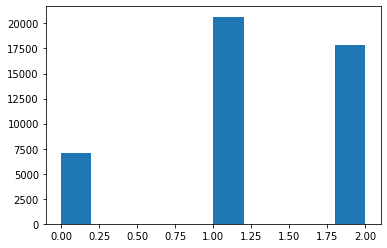

In [21]:
plt.hist(train_data)
plt.show()

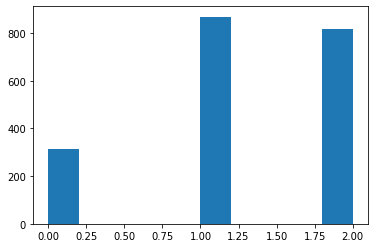

In [22]:
plt.hist(valid_data)
plt.show()

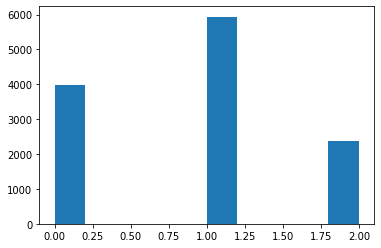

In [23]:
plt.hist(test_data)
plt.show()

In [33]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, 
                 vocab_size=100_000,
                 embedd_dim=300,
                 embeddings=None, 
                 hidden_size=128,
                 dropout=0.5,
                 num_classes=2):
        
        super().__init__()

        self.emb_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedd_dim)
        if embeddings is not None:
            self.emb_layer.from_pretrained(torch.Tensor(embeddings), freeze=True)
        
        self.pooling = torch.mean
        self.batch_norm = nn.BatchNorm1d(embedd_dim)
        self.linear_1 = nn.Linear(embedd_dim, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_size, num_classes)

    def forward(self, text):
        x = self.emb_layer(text)
        x = self.pooling(x, dim=1)
        x = self.batch_norm(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)
        return x

In [34]:
model = DeepAverageNetwork(
    vocab_size=embeddings_matrix.shape[0],
    embedd_dim=embeddings_matrix.shape[-1],
    embeddings=embeddings_matrix,
    hidden_size=64,
    dropout=0.2,
    num_classes=3
)

In [35]:
model

DeepAverageNetwork(
  (emb_layer): Embedding(100000, 300)
  (batch_norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_1): Linear(in_features=300, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=3, bias=True)
)

## Задайте функцию потерь и оптимизатор

In [36]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model.to(device)
criterion.to(device)

CrossEntropyLoss()

## Сделайте цикл обучения

In [37]:
from sklearn.metrics import f1_score

In [38]:
def train(model, loader, criterion, optimizer, last_n_losses=500):
    
    losses = []
    f1 = []
    
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Train")

    model.train()

    for i, (texts, ys) in progress_bar:
        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze() 
        loss = criterion(predictions, ys.to(device))
        
        loss.backward()
        optimizer.step()
        
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        losses.append(loss.item())
        f1.append(f1_score(y_true, preds, average="weighted"))

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return np.mean(losses), np.mean(f1)

In [39]:
def evaluate(model, loader, criterion, last_n_losses=500):
    
    losses = []
    f1 = []

    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Validate")

    model.eval()
    
    with torch.no_grad():
        for i, (texts, ys) in progress_bar:
            predictions = model(texts.to(device)).squeeze() 
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            
            losses.append(loss.item())
            f1.append(f1_score(y_true, preds, average="weighted"))
            
            progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

            progress_bar.update()

    progress_bar.close()
    
    return np.mean(losses), np.mean(f1)

In [40]:
def test(model, loader):
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for (texts, ys) in loader:
            predictions = model(texts.to(device)).squeeze() 
            y_pred.extend(predictions.detach().to('cpu').numpy().argmax(1).tolist())
            y_true.extend(ys.tolist())
    
    return y_true, y_pred

In [41]:
NUM_EPOCHS = 40 # Задайте количество эпох

train_losses = []
validation_losses = []

train_f1 = []
validation_f1 = []

for n_epoch in range(NUM_EPOCHS): 
    message = f'Epoch: {n_epoch + 1}\n'
    # train    
    mean_train_loss, mean_train_f1 = train(model=model, 
                           loader=train_loader, 
                           criterion=criterion,
                           optimizer=optimizer)
    
    train_losses.append(mean_train_loss)
    train_f1.append(mean_train_f1)

    message += f'Train: loss - {mean_train_loss:.4f} | f1-weight - {mean_train_f1:.4f}\n'
    
    # validation
    mean_validation_loss, mean_validation_f1 = evaluate(model=model, 
                           loader=valid_loader, 
                           criterion=criterion)
    
    validation_losses.append(mean_validation_loss)
    validation_f1.append(mean_validation_f1)
    
    message += f'Validation: loss - {mean_validation_loss:.4f} | f1-weight - {mean_validation_f1:.4f}'
    
    print(message)
    
# test
y_true, y_pred = test(model, test_loader)

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1
Train: loss - 0.9619 | f1-weight - 0.4846
Validation: loss - 0.9488 | f1-weight - 0.4940


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2
Train: loss - 0.9084 | f1-weight - 0.5341
Validation: loss - 0.9261 | f1-weight - 0.5349


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3
Train: loss - 0.8801 | f1-weight - 0.5604
Validation: loss - 0.9123 | f1-weight - 0.5314


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4
Train: loss - 0.8621 | f1-weight - 0.5733
Validation: loss - 0.8923 | f1-weight - 0.5512


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5
Train: loss - 0.8459 | f1-weight - 0.5850
Validation: loss - 0.8937 | f1-weight - 0.5506


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6
Train: loss - 0.8350 | f1-weight - 0.5954
Validation: loss - 0.8794 | f1-weight - 0.5747


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7
Train: loss - 0.8264 | f1-weight - 0.6022
Validation: loss - 0.8790 | f1-weight - 0.5699


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8
Train: loss - 0.8165 | f1-weight - 0.6091
Validation: loss - 0.8841 | f1-weight - 0.5675


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9
Train: loss - 0.8091 | f1-weight - 0.6159
Validation: loss - 0.8783 | f1-weight - 0.5806


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10
Train: loss - 0.8010 | f1-weight - 0.6219
Validation: loss - 0.8722 | f1-weight - 0.5772


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11
Train: loss - 0.7948 | f1-weight - 0.6243
Validation: loss - 0.8770 | f1-weight - 0.5836


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12
Train: loss - 0.7886 | f1-weight - 0.6287
Validation: loss - 0.8690 | f1-weight - 0.5809


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13
Train: loss - 0.7817 | f1-weight - 0.6320
Validation: loss - 0.8729 | f1-weight - 0.5789


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14
Train: loss - 0.7773 | f1-weight - 0.6377
Validation: loss - 0.8795 | f1-weight - 0.5845


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15
Train: loss - 0.7719 | f1-weight - 0.6401
Validation: loss - 0.8948 | f1-weight - 0.5758


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16
Train: loss - 0.7657 | f1-weight - 0.6446
Validation: loss - 0.8795 | f1-weight - 0.5798


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17
Train: loss - 0.7600 | f1-weight - 0.6458
Validation: loss - 0.8922 | f1-weight - 0.5765


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18
Train: loss - 0.7551 | f1-weight - 0.6519
Validation: loss - 0.8880 | f1-weight - 0.5736


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19
Train: loss - 0.7506 | f1-weight - 0.6558
Validation: loss - 0.8920 | f1-weight - 0.5815


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20
Train: loss - 0.7457 | f1-weight - 0.6570
Validation: loss - 0.8874 | f1-weight - 0.5863


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21
Train: loss - 0.7390 | f1-weight - 0.6612
Validation: loss - 0.9220 | f1-weight - 0.5678


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22
Train: loss - 0.7358 | f1-weight - 0.6639
Validation: loss - 0.9232 | f1-weight - 0.5660


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23
Train: loss - 0.7303 | f1-weight - 0.6690
Validation: loss - 0.9049 | f1-weight - 0.5861


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24
Train: loss - 0.7265 | f1-weight - 0.6680
Validation: loss - 0.9016 | f1-weight - 0.5929


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25
Train: loss - 0.7221 | f1-weight - 0.6728
Validation: loss - 0.9092 | f1-weight - 0.5901


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26
Train: loss - 0.7169 | f1-weight - 0.6746
Validation: loss - 0.9005 | f1-weight - 0.5873


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27
Train: loss - 0.7097 | f1-weight - 0.6795
Validation: loss - 0.9190 | f1-weight - 0.5798


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28
Train: loss - 0.7077 | f1-weight - 0.6813
Validation: loss - 0.9182 | f1-weight - 0.5808


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29
Train: loss - 0.7008 | f1-weight - 0.6835
Validation: loss - 0.9314 | f1-weight - 0.5787


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30
Train: loss - 0.6961 | f1-weight - 0.6869
Validation: loss - 0.9189 | f1-weight - 0.5873


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31
Train: loss - 0.6943 | f1-weight - 0.6880
Validation: loss - 0.9428 | f1-weight - 0.5665


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32
Train: loss - 0.6860 | f1-weight - 0.6929
Validation: loss - 0.9333 | f1-weight - 0.5802


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33
Train: loss - 0.6843 | f1-weight - 0.6941
Validation: loss - 0.9426 | f1-weight - 0.5906


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34
Train: loss - 0.6791 | f1-weight - 0.6969
Validation: loss - 0.9431 | f1-weight - 0.5818


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35
Train: loss - 0.6743 | f1-weight - 0.6974
Validation: loss - 0.9493 | f1-weight - 0.5879


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36
Train: loss - 0.6694 | f1-weight - 0.7038
Validation: loss - 0.9369 | f1-weight - 0.5884


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37
Train: loss - 0.6658 | f1-weight - 0.7027
Validation: loss - 0.9668 | f1-weight - 0.5808


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38
Train: loss - 0.6621 | f1-weight - 0.7069
Validation: loss - 0.9702 | f1-weight - 0.5762


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39
Train: loss - 0.6543 | f1-weight - 0.7096
Validation: loss - 0.9797 | f1-weight - 0.5802


/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train:   0%|          | 0/357 [00:00<?, ?it/s]

/home/yudina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Validate:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40
Train: loss - 0.6493 | f1-weight - 0.7117
Validation: loss - 0.9805 | f1-weight - 0.5810


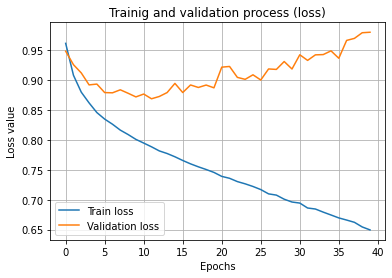

In [52]:
plt.plot(train_losses, label="Train loss")
plt.plot(validation_losses, label="Validation loss")
plt.title("Trainig and validation process (loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.grid()

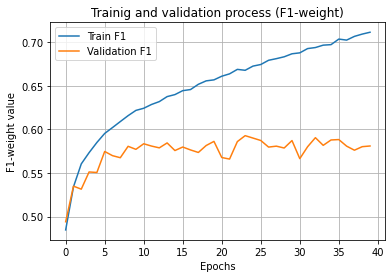

In [53]:
plt.plot(train_f1, label="Train F1")
plt.plot(validation_f1, label="Validation F1")
plt.title("Trainig and validation process (F1-weight)")
plt.xlabel("Epochs")
plt.ylabel("F1-weight value")
plt.legend()
plt.grid()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.37      0.43      3972
           1       0.58      0.64      0.61      5937
           2       0.41      0.49      0.45      2375

    accuracy                           0.53     12284
   macro avg       0.50      0.50      0.50     12284
weighted avg       0.53      0.53      0.52     12284



In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

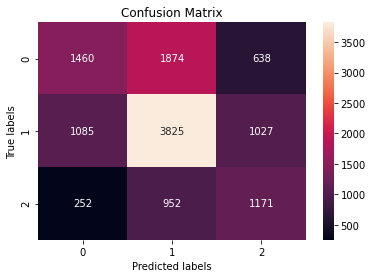

In [57]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Прежде всего по графику loss-а видно, что где-то после 10ой эпохи моя модель начинает переобучаться - видно по лоссу на валидации, что он начинает ползти вверх. При этом на трэйн-данных loss падает гладко, постепенно, что хорошо. График изменения метрики F1-weight показывает, что трэйн-данных она постепенно увеличивалась, а вот на данных для валидации застряла где-то в районе 0.55-0.6. По Confusion матрице видно, что лучше всего предсказывается 1ый класс, хуже - 2ой. Также видно, что и 0 (негативный), и 2ой (позитивный) классы чаще путают с первым-нейтральным (причем для нулевого предсказание как первого происходит чаще, чем правильное предсказание - скорее всего это происходит из-за того, что 0 класс самый маленький, а еще, возможно, из-за того, что модель не может выделить сарказм как негативную тональность). 0 и 2ой класс друг с другом модель почти не путает (что вообще-то неплохо!). По classification_report же видно, что f1-мера для 0 и 2го классов меньше, чем для 1го. Хочется сказать, что **модель действительно переобучилась и умеет более-менее предсказывать только 1ый класс**. Стоило добавить раннюю остановку. 

Возможно, проблема в данных - классы несбалансированы, у меня нет вообще никакой предобработки данных. Также, можно было посмотреть на качество модели без использования эмбеддингов (вдруг эти эмбеддинги плохо подходят к данным). А еще можно было использовать другой токенизатор.

Чем можно улучшить? Попробовать разные гиперпараметры. Я добавила в модель и батч-нормализацию, и дропаут, но это мне не сильно помогло). В этой архитектуре использовалось усреднее эмбеддингов, а можно было еще попробовать min/max poling. 